In [60]:
import pandas as pd
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

sns.set_theme()
%matplotlib inline

In [37]:
json_results_file = '../predictions/multiple_imputation_median_pooling.json'

predictions = None
with open(json_results_file, 'r') as file:
    data_json = json.load(file)
    for model_full_name, df_data in data_json.items():
        model_short_name = model_full_name.split('_')[0]
        predictions = pd.DataFrame(df_data)
        break

predictions.head()

,y_test,binary_predictions,probabilities,patient_id
0,0,0,0.151226,25312
1,0,1,0.633058,59342
2,0,0,0.007471,50777
3,0,0,0.049166,46918
4,0,0,0.012339,34377


In [38]:
data_file = '../data/training_v2.csv'
data = pd.read_csv(data_file)
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [39]:
predictions = predictions.join(data, on='patient_id', rsuffix='_data', how='left')[['y_test', 'probabilities', 'age', 'ethnicity', 'gender']]
predictions = predictions.rename(columns={'y_test': 'labels', 'probabilities': 'predictions'})
predictions.head()

,labels,predictions,age,ethnicity,gender
0,0,0.151226,57.0,African American,F
1,0,0.633058,48.0,Caucasian,M
2,0,0.007471,34.0,Caucasian,F
3,0,0.049166,60.0,Caucasian,F
4,0,0.012339,80.0,Caucasian,F


In [5]:
data = pd.read_csv("XGBClassifier_predictions.csv")

In [25]:
def plot_roc_curves(df, column_name, label_col="labels", pred_col="predictions", value_names={}):
  """
  Plots ROC curves for different groups based on a specified column.

  Args:
    df: pandas DataFrame containing data.
    column_name: Column name representing groups (e.g., "gender", "ethnicity").
    label_col: Column name containing true labels (default: "labels").
    pred_col: Column name containing predicted labels (default: "predictions").
    value_names: Dictionary mapping column values to custom labels (default: None).

  Returns:
    None. Plots the ROC curves to the current figure.
  """
  unique_values = sorted(df[column_name].unique())

  plt.figure(figsize=(10, 6))
  for i, value in enumerate(unique_values):
    group_data = df[df[column_name] == value]
    y_true = group_data[label_col]
    y_pred = group_data[pred_col]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    label = value_names.get(value, value)  # Use custom label if available
    plt.plot(fpr, tpr, label=label)

  # Add subtle y=x line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)

  # Customize plot and display
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"ROC Curves by {column_name}")
  plt.legend(title=column_name)
  plt.grid(True)
  plt.show()

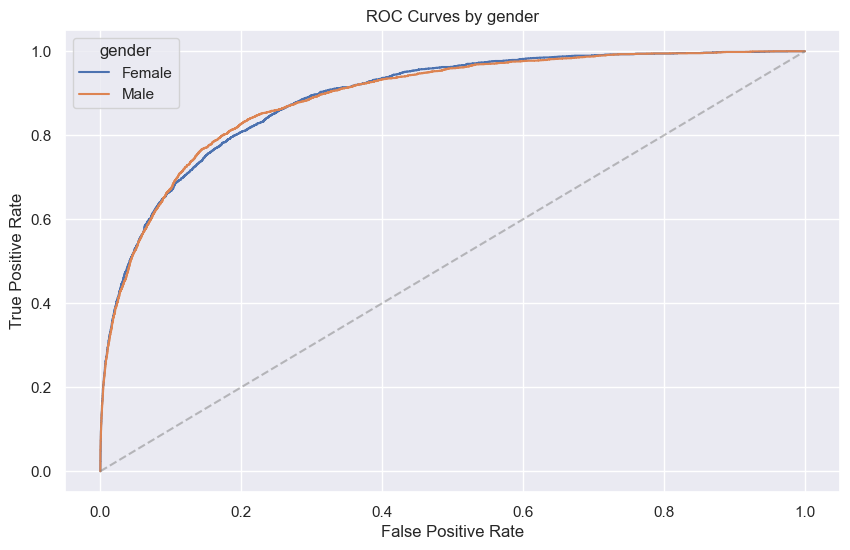

In [61]:
gender_labels = {
  'F': 'Female',
  'M': 'Male'
}

data_gender_drop_na = pd.DataFrame(predictions)
data_gender_drop_na.dropna(inplace=True)
plot_roc_curves(data_gender_drop_na, 'gender', value_names=gender_labels)

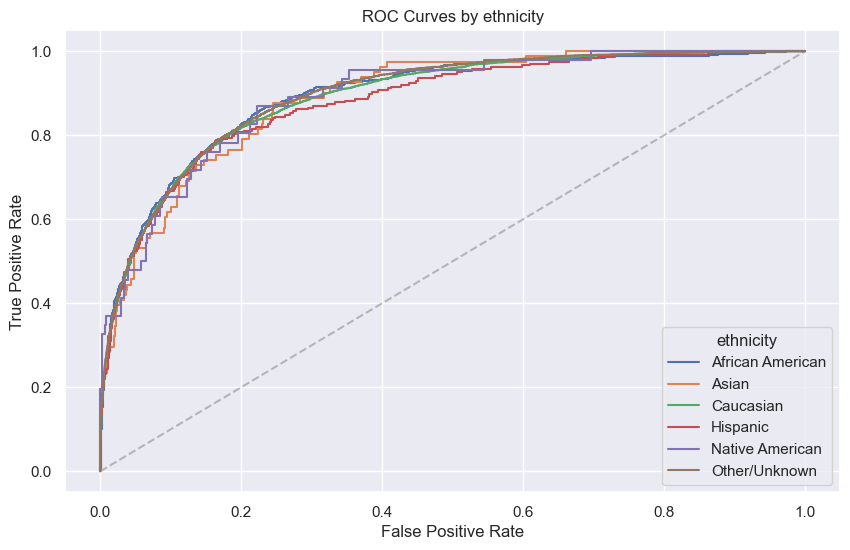

In [62]:
predictions['ethnicity'] = predictions['ethnicity'].fillna('Other/Unknown')
plot_roc_curves(predictions, 'ethnicity')

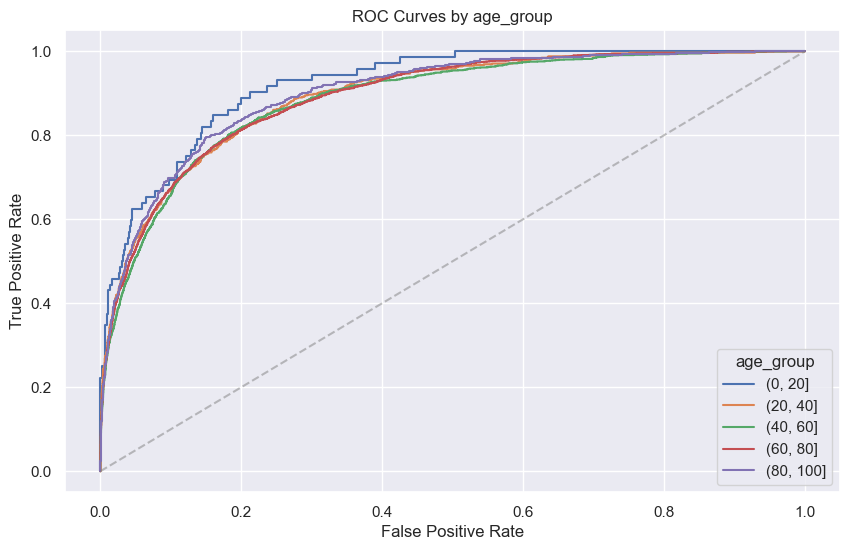

In [75]:
# Define age groups with 20-year steps
age_groups = range(0, 101, 20)
age_groups_labels = [pd.Interval(left=b, right=b+20) for b in range(0, 101, 20)]

# Use pd.cut to create the age group column based on boundaries and labels
data_with_age_groups = predictions.copy()

# data_with_age_groups['age_group'] = pd.cut(data_with_age_groups['age'], age_groups, labels=age_groups[:-1])
data_with_age_groups['age_group'] = pd.cut(data_with_age_groups['age'], age_groups, labels=age_groups_labels[:-1])
data_with_age_groups.dropna(inplace=True)

plot_roc_curves(data_with_age_groups, 'age_group')

In [44]:
data_with_age_groups.to_csv('XGBClassifier_predictions_with_protected_groups.csv')

## Multi-Calibration

In [109]:
def calculate_odds_ratio(subgroup_df):
    """Calculates the odds ratio for a given subgroup using your formula.

    Args:
        subgroup_df (pd.DataFrame): A DataFrame containing data for a specific subgroup.

    Returns:
        float: The odds ratio for the subgroup using your formula.
    """

    avg_prediction = subgroup_df["predictions"].mean()
    avg_outcome = subgroup_df["labels"].mean()

    if avg_prediction == 1 or avg_outcome == 0 or avg_outcome == 1:
        # Handle cases where division by zero would occur
        return None

    # Calculate odds ratio using your formula (not recommended for calibration)
    odds_ratio = (avg_prediction / (1 - avg_prediction)) / (avg_outcome / (1 - avg_outcome))

    return odds_ratio


# Calculate odds ratio for each subgroup
subgroups = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])
calibration_in_the_large = pd.DataFrame(subgroups.apply(calculate_odds_ratio), columns=['calibration_in_the_large_before'])
calibration_in_the_large.dropna(inplace=True)

/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_6834/978972609.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroups = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])


In [ ]:
protected_groups = ['age_groups', 'ethnicity', 'gender']


In [90]:
alpha = 0.0005
done = False
while not done:
    done = True
    max_violation = 0
    for group_index, group in calibration_in_the_large.iterrows():
        violation = 

<Axes: title={'center': 'Clibration in the large density'}, ylabel='Density'>

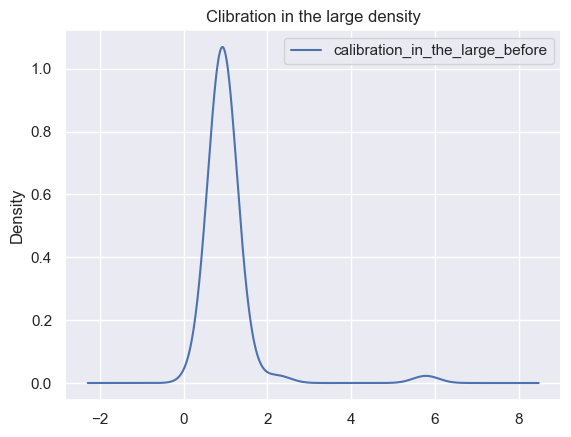

In [112]:
calibration_in_the_large.plot(kind='density', title='Clibration in the large density',)